In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
import requests
import sys

from io import StringIO
from pathlib import Path

repo_path = Path("C:/Users/Wyss User/Documents/EVs/bdev_mass_spec")
os.chdir(repo_path)
sys.path.append(str(repo_path / "src"))

from brainrnaseq_specificity import map_hgnc_ids, create_enrichment_dataframe, calculate_enrichment, cell_type_enrichment, mean_cell_type, process_hgnc_data
from deeptmhmm_localization import parse_gz_file, tmhmm_localization, identify_localization
from config import hgnc_ids, CELL_TYPES

output_directory = Path(r"outputs\pd_1_output")
raw_data_path = Path(r"data\ms_1_raw.xlsx")
uniprot_fasta_database = Path(r"data\uniprot_fasta_database.gz")
brain_rna_seq_raw_path = Path(r"data\240411_brain_rna_seq_raw.csv")

In [20]:
samples_dict = {
    "Sum Intensity P1": "GFP",
    "Sum Intensity P2": "AQP4 PD1",
    "Sum Intensity P3": "Unconjugated Beads",
    "Sum Intensity P4": "AQP4 PD2",
    "Sum Intensity P5": "CD9"
}

In [38]:
def extract_protein_label(df: pd.DataFrame, label: str) -> pd.Index:
    """Extract protein labels (UniProt ID or name) from the index of the DataFrame."""
    if label == "name":
        return df.index.str.extract(r'\|([\w]+)\_', expand=False)
    elif label == "uniprot":
        return df.index.str.extract(r'\|([\w]+)\|', expand=False)
    else:
            raise ValueError("Invalid label. Use 'name' or 'uniprot'.")

def normalize_raw_data(df: pd.DataFrame, col_dict: dict) -> pd.DataFrame:
    """
    Normalize raw mass spec pulldown data.
    - Select pulldown and reference columns
    - Replace NF values with 0.0
    - Convert object-type columns to numeric
    - Normalize by row maximum
    - Filter to only include human protein hits
    - Set index as UniProt IDs
    """
    
    # filter the raw data frame to only include the columns with pulldown data
    selected_columns = list(col_dict.keys()) + ['reference']
    # selected_columns.append('reference')
    filtered_df = df[selected_columns].copy()

    # Set reference column as index
    filtered_df.set_index('reference', inplace=True)

    # replace all NF values with 0.0 and convert all object columns to numeric
    filtered_df = filtered_df.replace("NF", 0.0)
    for col in filtered_df.select_dtypes(include="object").columns:
        filtered_df[col] = pd.to_numeric(filtered_df[col], errors="coerce")

    # Normalize each row by its max value (0 to 1 range, 1 = highest possible intensity)
    row_max = filtered_df.max(axis=1)
    filtered_df = filtered_df.div(row_max, axis=0)

    # filter data to only include human protein hits
    human_df = filtered_df[filtered_df.index.str.contains("HUMAN")]

    # Set the index as uniprot IDs
    human_df.index = extract_protein_label(human_df, "uniprot")
    return human_df

In [42]:
raw_data = pd.read_excel(raw_data_path, sheet_name = "Sheet2")
human_data = normalize_raw_data(raw_data, samples_dict)

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_27940\2813533565.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df = filtered_df.replace("NF", 0.0)


In [47]:
# Load and process the Brain RNA-Seq data
brain_rna_seq = pd.read_csv(brain_rna_seq_raw_path)
hgnc_uniprot_mapping_data = process_hgnc_data(hgnc_ids)
brain_rna_seq = (
    brain_rna_seq.merge(
        hgnc_uniprot_mapping_data, left_on="id", right_on="hgnc_id", how="inner"
    )
    .dropna(subset=["uniprot_ids"])
    .drop_duplicates(subset=["uniprot_ids"])
)
brain_rna_seq.set_index(
    ["uniprot_ids", "symbol", "name", "alias_symbol", "alias_name"], inplace=True
)
cell_type_dfs = {
    cell_type: mean_cell_type(brain_rna_seq, cell_type)
    for cell_type in [
        "astrocyte",
        "endothelial",
        "microglia",
        "oligodendrocyte",
        "neuron",
    ]
}

all_cell_types = pd.concat(cell_type_dfs.values(), axis=1)
expression_df = all_cell_types[CELL_TYPES.values()]

tau_score_cutoff = 0.75
enrichment_values = expression_df.apply(
    lambda row: calculate_enrichment(row, "tau"), axis=1
)
high_tau_proteins = enrichment_values[enrichment_values > tau_score_cutoff].index.get_level_values("uniprot_ids").tolist()

In [48]:
def max_cell_type_expression(cell_type, expression_df):
    expression_df_copy = expression_df.copy()
    expression_df_copy['max'] = expression_df.max(axis=1)
    return expression_df_copy[expression_df_copy[cell_type] == expression_df_copy["max"]].index.get_level_values("uniprot_ids").tolist()

In [49]:
high_astrocyte = max_cell_type_expression("mature", expression_df)
high_microglia = max_cell_type_expression("microglla", expression_df)
high_oligodendrocyte = max_cell_type_expression("oligodendrocyte", expression_df)
high_neuron = max_cell_type_expression("neuron", expression_df)
high_endothelial = max_cell_type_expression("endothelial", expression_df)

astrocyte_specific = set(high_astrocyte) & set(high_tau_proteins)
microglia_specific = set(high_microglia) & set(high_tau_proteins)
oligodendrocyte_specific = set(high_oligodendrocyte) & set(high_tau_proteins)
neuron_specific = set(high_neuron) & set(high_tau_proteins)
endothelial_specific = set(high_endothelial) & set(high_tau_proteins)

In [124]:
enriched_targets = human_data[
    (human_data["Sum Intensity P1"] < 0.01)
    & (human_data["Sum Intensity P3"] < 0.01)
    ]

# p2_enriched_targets = enriched_targets[enriched_targets["Sum Intensity P2"] > 0.85]
# p4_enriched_targets = enriched_targets[enriched_targets["Sum Intensity P4"] > 0.85]
# p5_enriched_targets = enriched_targets[enriched_targets["Sum Intensity P5"] > 0.85]

c:\Users\Wyss User\anaconda3\envs\mass_spec\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1633: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Wyss User\anaconda3\envs\mass_spec\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


Text(0.5, 1.0, 'Microglia')

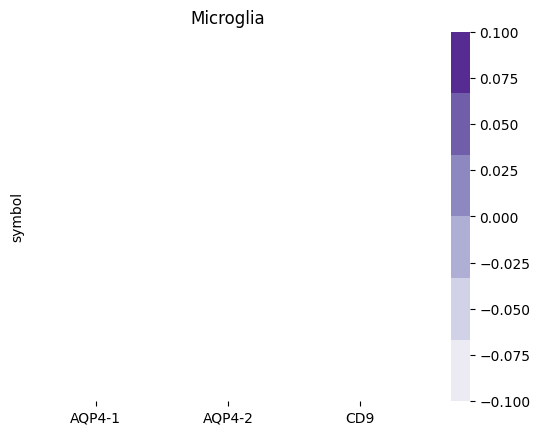

In [125]:
df_list=enriched_targets[enriched_targets.index.isin(microglia_specific)].index.tolist()

column_names = {
    "Sum Intensity P2": "AQP4-1",
    "Sum Intensity P4": "AQP4-2",
    "Sum Intensity P5": "CD9"
}

df = filtered_data[filtered_data.index.isin(df_list)]
heatmap_data = pd.merge(hgnc_uniprot_mapping_data, df, left_on = "uniprot_ids", right_index = True).set_index("symbol")

heatmap_data = heatmap_data[["Sum Intensity P2", "Sum Intensity P4", "Sum Intensity P5"]]
heatmap_data.rename(mapper=column_names, axis=1, inplace=True)
heatmap_data.replace(to_replace="NF", value=0, inplace=True)
# heatmap_data = np.log1p(heatmap_data)  # log1p(x) = log(1 + x)


colormap = sns.color_palette("Purples") 

sns.heatmap(heatmap_data, cmap=colormap, robust=True, annot=True)
plt.title("Microglia")